### Fitting to the sidelobes

### Goal:
Extract the plate scale and effective incident spectrum from the sidelobes.

### Ideas:
Forward model everything? Not going to be efficient since generating a single image takes ~100 seconds with such a large FoV. And splitting the image up into 4 smaller squares around the sidelobes doesn't help. Neither does doing a tiny stamp for each wavelength. Tested using poppy. Perhaps a switch is needed to tell it to use an MFT or something?

Instead, might have to approximate PSF as an Airy pattern and see how far we can get. Once something works, can always swap in the image generation infrastructure for something else.

Airy pattern takes ~1s per image.

### Results:
(10 ims)

With no jitter and 35000 peak photons and 10% of light into sidelobes:\
Plate scale: 0.155999 +/- 0.000002.  Error: 4.91 +/- 10.91ppm\
PSF width: 8.07898 +/- 0.00146939\
Teff: 5789.657777 +/- 1.012591.  Error: 59.11 +/- 174.89ppm\
Flux: 0.190572 +/- 0.00154788\
Wave: 549.792406 +/- 0.000625.  Error: 0.39 +/- 1.14ppm

With no jitter and 3500 peak photons and 10% of light into sidelobes:\
Plate scale: 0.155998 +/- 0.000002.  Error: 15.69 +/- 13.62ppm\
PSF width: 8.07879 +/- 0.00608347\
Teff: 5794.055082 +/- 8.107078.  Error: -700.36 +/- 1400.19ppm\
Flux: 0.176722 +/- 0.00530945\
Wave: 549.784205 +/- 0.017109.  Error: 15.30 +/- 31.12ppm

With no jitter and 350 peak photons and 10% of light into sidelobes:\
Plate scale: 0.156003 +/- 0.000007.  Error: -19.99 +/- 43.97ppm\
PSF width: 8.06318 +/- 0.0250308\
Teff: 5796.964222 +/- 13.485331.  Error: -1202.80 +/- 2329.07ppm\
Flux: 0.140746 +/- 0.0053517\
Wave: 549.772054 +/- 0.025910.  Error: 37.40 +/- 47.13ppm

With jitter and 35000 peak photons and 10% of light into sidelobes:\
Plate scale: 0.156000 +/- 0.000001.  Error: 2.90 +/- 7.59ppm\
PSF width: 8.06598 +/- 0.00117904\
Teff: 5794.485613 +/- 7.049986.  Error: -774.72 +/- 1217.61ppm\
Flux: 0.189882 +/- 0.0018616\
Wave: 549.786434 +/- 0.009444.  Error: 11.25 +/- 17.18ppm


### Tried starting all fitters at the same point:
(30 ims)

With jitter and 35000 peak photons:\
Plate scale: 0.156000 +/- 0.000001.  Error: -1.01 +/- 8.49ppm\
PSF width: 8.06704 +/- 0.00193192\
Teff: 5789.777747 +/- 0.913469.  Error: 38.39 +/- 157.77ppm\
Flux: 0.190299 +/- 0.00155361\

With 0.05nm shifts in the filter central wavelength and jitter and 35000 peak photons:\
Plate scale: 0.156001 +/- 0.000006.  Error: -6.27 +/- 38.81ppm\
PSF width: 8.06674 +/- 0.0017712\
Teff: 5789.784807 +/- 0.941029.  Error: 37.17 +/- 162.53ppm\
Flux: 0.190358 +/- 0.00245736\
Wave: 549.799228 +/- 0.000580.  Error: 0.24 +/- 1.05ppm

With no filter shifts, but with RVs and jitter and 35k peak photons:\
Inconsistent with actual values! But didn't put RV as a free parameter\
Plate scale: 0.156006 +/- 0.000001.  Error: -41.10 +/- 7.90ppm\
PSF width: 8.06678 +/- 0.0021512\
Teff: 5795.353436 +/- 6.631792.  Error: -924.60 +/- 1145.39ppm\
Flux: 0.190432 +/- 0.00205627 \
Wave: 549.787500 +/- 0.007624.  Error: 9.31 +/- 13.87ppm

In [1]:
from importlib import reload
import poppy
import poppy_model
reload(poppy_model)
import numpy as np
import matplotlib.pyplot as plt
import pysynphot as S
from matplotlib.colors import LogNorm
import time

from astropy.io import fits
import scipy
import glob

In [2]:
# What are we fitting to?
sim_dir = 'sims/jitter_35k/'

# Load one image to get the relevant params
image,header = fits.getdata(sim_dir+'0.fits',header=True)

In [3]:
# Fitting params
n_wavs = 200

# Simulation params
npix = image.shape[0]
pscale = header['pscale']
central_wav = header['central_wav']
width = header['width']

wavs = np.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges
filter_bandpass = poppy_model.supergaussian(wavs,central_wav,sigma=width)

In [4]:
# Set up our best model of the aperture
composite = poppy_model.TolimanAperture(add_grating=True,grating_fact=0.0003,telescope_diam=0.22,
                    central_wav=central_wav,achromatic_pupil=True,grating_amp=np.sqrt(0.1)) # 0.00012 gives R~750 diagonally

In [5]:
# Make a mask so it only concentrates on the residuals near the sidelobes
min_offset = poppy_model.diffraction_spot_offset(wavs.min(),composite,pscale)*np.sqrt(2)
max_offset = poppy_model.diffraction_spot_offset(wavs.max(),composite,pscale)*np.sqrt(2)
mean_offset = poppy_model.diffraction_spot_offset(wavs.mean(),composite,pscale)*np.sqrt(2)
x,y = np.indices(image.shape)
mask = (np.abs(x-y) <25) | (np.abs(x-(image.shape[0]-y)) <25)
mask = (np.sqrt((x-image.shape[0]//2)**2+(y-image.shape[0]//2)**2) > (min_offset-25)) & mask
mask = (np.sqrt((x-image.shape[0]//2)**2+(y-image.shape[0]//2)**2) < (max_offset+25)) & mask

In [6]:
def rough_centre(im,search_radius = 30,skip=2):
    
    # Make a thin mask 
    x,y = np.indices(im.shape)
    thin_mask = (np.abs(x-y) <2) | (np.abs(x-(image.shape[0]-y)) <2)
    thin_mask = (np.sqrt((x-image.shape[0]//2)**2+(y-image.shape[0]//2)**2) > (min_offset-2)) & thin_mask
    thin_mask = (np.sqrt((x-image.shape[0]//2)**2+(y-image.shape[0]//2)**2) < (max_offset+2)) & thin_mask

    # Convolve the image with the mask (manually to save time)
    xs = np.arange(-search_radius,search_radius,skip)
    ys = np.arange(-search_radius,search_radius,skip)
    conv = np.zeros((xs.size,ys.size))
    for x_ix,x in enumerate(xs):
        for y_ix,y in enumerate(ys):
            shifted_im = np.roll(im,x,axis=0)
            shifted_im = np.roll(shifted_im,y,axis=1)
            # Zero out the 
            if x>0:
                shifted_im[:x,:] = 0
            elif x<0:
                shifted_im[x:,:] = 0
            if y>0:
                shifted_im[:,:y] = 0
            elif y<0:
                shifted_im[:,y:] = 0
            conv[x_ix,y_ix] = np.sum(shifted_im[thin_mask])

    cen_ix = np.unravel_index(np.argmax(conv),conv.shape)
    cen = [xs[cen_ix[0]],ys[cen_ix[1]]]
    return cen


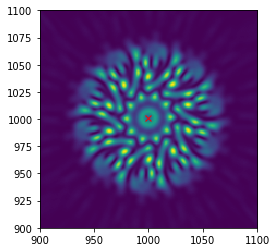

In [7]:
im,header = fits.getdata(sim_dir+'0.fits',header=True)
cen = rough_centre(im,search_radius = 3,skip=1)
# plt.imshow(conv)
# plt.show()
plt.imshow(im)
plt.xlim(900,1100)
plt.ylim(900,1100)
# plt.plot(im.shape[1]//2,im.shape[0]//2,'ko')
plt.plot(im.shape[1]//2-cen[1],im.shape[0]//2-cen[0],'rx')

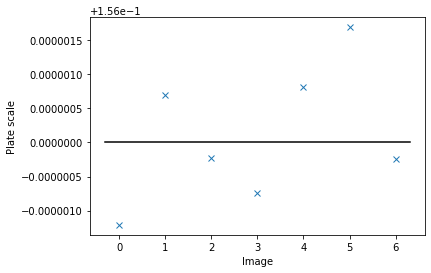

`xtol` termination condition is satisfied.
Function evals: 7
Done 6 : [ 1.55999758e-01  8.06849877e+00  5.79104514e+03  1.90498772e-01
 -1.67565180e+00 -4.20333739e-01]


In [ ]:
%%time
from IPython.display import clear_output

# Loop through the images
psf_radius = 8.05
# Plate scale, PSF radius, teff, flux, xcen,ycen, filter centre, RV (km/s)
starting_params = [pscale,psf_radius,5790,0.19,0,0]#,550e-9,-22.3] 
starting_params = np.array(starting_params)

wdir = '/Users/cheetham/code/toliman/Toliman/Sidelobe_fit/sims/jitter_35k/'
ims = glob.glob(wdir+'*.fits')
ims.sort()
n = len(ims)

best_fit_params = np.zeros((n,starting_params.size))

for ix,fn in enumerate(ims):
    
    # temp hack
#     if ix >5:
#         continue
    
    # Load and normalize by peak on one sidelobe
    im = fits.getdata(fn)
    im = im/np.max(im[0:500,0:500])
    
    # Get a rough centre position
    cen = rough_centre(im,search_radius = 3,skip=1)
    
    params = starting_params
    
    kw = {'image':im,'cutout_sz':100,'wavs':wavs,'aperture':composite,'mask':mask}
    kw['filter_centre'] = 550e-9 # fix it!
    kw['RV'] = -22.3 # fix it!
    
    min_bounds = [0.15,7,5700,0.,-50,-50]#,540e-9,-22.6]
    max_bounds = [0.16,9,5900,np.inf,50,50]#,560e-9,-22.0]
    
    bounds=(min_bounds,max_bounds)
    
#     resids = poppy_model.airy_model_residuals(params,image=im,cutout_sz=100,wavs=wavs,aperture=composite)
#     resids_2d = np.reshape(resids,im.shape)
#     plt.imshow(resids_2d*mask,vmin=-1e-1,vmax=1e-1)
    
    fit = scipy.optimize.least_squares(poppy_model.airy_model_residuals,params,method='trf',
                                       ftol=None,xtol=1e-7,kwargs=kw,bounds=bounds)
    best_fit_params[ix] = fit.x
    
    clear_output(wait=True)
    plt.plot(best_fit_params[:ix+1,0],'x');plt.xlabel('Image');plt.ylabel('Plate scale')
    plt.plot(plt.xlim(),[pscale,pscale],'k')
    plt.show()

    print(fit.message)
    print('Function evals:',fit.nfev)
    print('Done',ix,':',fit.x)

Plate scale: 0.156000 +/- 0.000001.  Error: 1.59 +/- 8.99ppm
PSF width: 8.06736 +/- 0.00228132
Teff: 5791.525362 +/- 4.621404.  Error: -263.45 +/- 798.17ppm
Flux: 0.189872 +/- 0.00171628


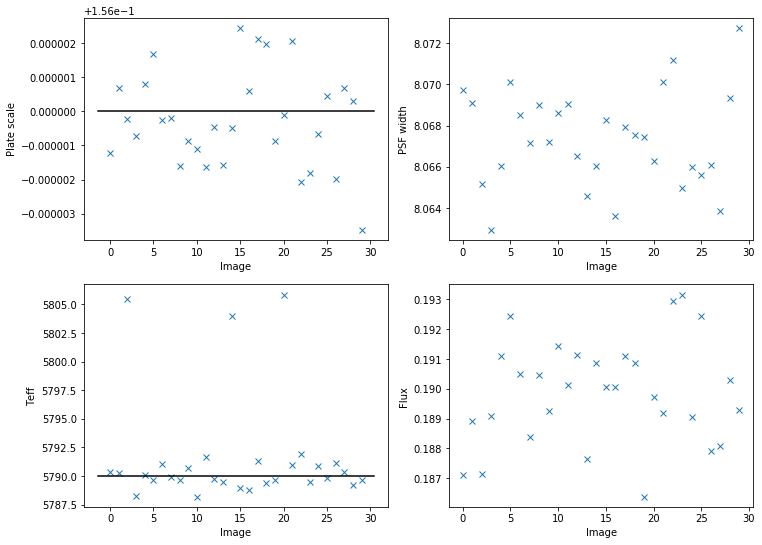

In [16]:
# Plot the parameters
fig,axs = plt.subplots(2,2,clear=True,figsize=(12,9))
((ax1,ax2),(ax3,ax4)) = axs

params = ['Plate scale','PSF width','Teff','Flux']
actual_vals = [pscale,None,header['primary_teff'],None]
for ix,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.plot(best_fit_params[:,ix],'x')
    
    actual_val = actual_vals[ix]
    if actual_val is not None:
        ax.plot(ax.get_xlim(),[actual_val,actual_val],'k')
        
    ax.set_xlabel('Image')
    ax.set_ylabel(params[ix])
    
    val = np.mean(best_fit_params[:,ix])
    err = np.std(best_fit_params[:,ix])
    
    if actual_val is not None:
        line = '{0}: {1:.6F} +/- {2:.6F}.  Error: {3:.2F} +/- {4:.2F}ppm'
        print(line.format(params[ix],val,err,(actual_vals[ix]-val)/actual_vals[ix]*1e6,err/actual_vals[ix]*1e6))
    else:
        line = '{0}: {1:.6} +/- {2:.6}'
        print(line.format(params[ix],val,np.std(best_fit_params[:,ix])))


In [17]:
# How does Teff convert into central wavelength change?
eff_waves = np.zeros(best_fit_params.shape[0])
for ix in range(best_fit_params.shape[0]):
    measured_teff = best_fit_params[ix,2]
    
    measured_z = 0.2
    measured_logg = 4.3
    acenA = S.Icat('phoenix',measured_teff,measured_z,measured_logg)

    specA = acenA.sample(wavs*1e10) # This needs angstroms as input

    # Find the mean wavelength
    eff_wave = np.sum(specA*wavs)/np.sum(specA)
    eff_waves[ix] = eff_wave
    
# What should it be?
acenA = S.Icat('phoenix',header['primary_teff'],header['primary_z'],header['primary_logg'])
specA = acenA.sample(wavs*1e10) # This needs angstroms as input
actual_eff_wave = np.sum(specA*wavs)/np.sum(specA)*1e9

val = np.mean(eff_waves)*1e9
err = np.std(eff_waves)*1e9

line = '{0}: {1:.6F} +/- {2:.6F}.  Error: {3:.2F} +/- {4:.2F}ppm'
print(line.format('Wave',val,err,(actual_eff_wave-val)/actual_eff_wave*1e6,err/actual_eff_wave*1e6))

Wave: 549.790617 +/- 0.006194.  Error: 3.64 +/- 11.27ppm


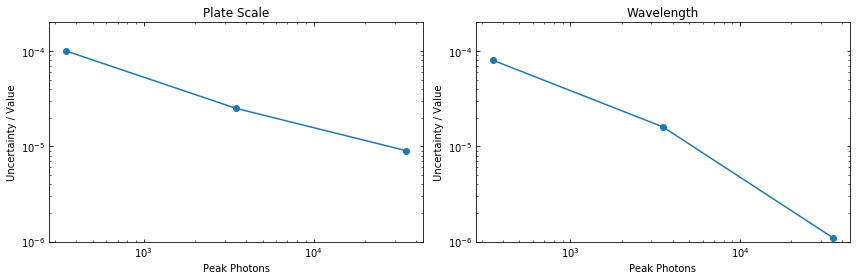

In [63]:
photons = [35000,3500,350]
ps_err=  np.array([9,25,99.9])
wave_err = np.array([1.1,16,80])

plt.figure(figsize=(12,4))
for ix in range(2):
    plt.subplot(1,2,ix+1)
    plt.plot(photons,[ps_err,wave_err][ix]*1e-6,'-o')
    plt.xlabel('Peak Photons')
    plt.ylabel('Uncertainty / Value')
    plt.title(['Plate Scale','Wavelength'][ix])
    plt.ylim(1e-6,2e-4)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().tick_params(axis='both',which='both',direction='in',top=True,right=True)
plt.tight_layout()
plt.savefig('/Users/cheetham/Desktop/toliman_plate_scale_uncertainty.pdf')